In [1]:
# Importing libraries
from random import sample
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 200)
%matplotlib inline

/usr/local/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Loading the dataset
data = pd.read_csv('training_v2.csv')

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [3]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [4]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
random.seed(42)
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [5]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [6]:
new_data.shape

(15830, 186)

In [7]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,46773,124716,100,0,45.0,16.127253,1,Caucasian,F,172.7,Operating Room,Operating Room / Recovery,495,admit,Med-Surg ICU,20.154861,0,48.10,NaN,219.0,1504.01,1,0.0,NaN,12.0,0.50,NaN,4.0,6.0,0.0,1.0,197.0,143.0,22.1,0.0,47.0,NaN,NaN,NaN,NaN,9.0,138.0,35.7,1106.0064,1.0,7.61,80.0,56.0,99.0,41.0,99.0,41.0,143.0,88.0,102.0,75.0,102.0,47.0,102.0,47.0,23.0,9.0,100.0,94.0,139.0,107.0,130.0,66.0,130.0,66.00,37.5,35.7,NaN,NaN,71.0,41.0,71.0,41.0,143.0,106.0,NaN,NaN,77.0,47.0,77.0,47.0,23.0,9.0,100.0,99.0,NaN,NaN,99.0,66.0,99.0,66.0,36.4,35.7,NaN,NaN,NaN,NaN,12.0,12.0,8.7,7.6,0.60,0.50,197.0,173.0,24.0,18.0,10.8,7.8,30.0,22.1,1.62,1.37,2.50,2.50,290.0,250.0,4.3,3.9,140.0,138.0,13.93,7.610,NaN,NaN,NaN,NaN,12.0,12.0,7.6,7.6,0.60,0.60,197.0,197.0,18.0,18.0,10.8,10.8,30.0,30.0,1.62,1.37,2.5,2.5,290.0,290.0,4.3,4.3,140.0,140.0,13.93,13.93,23.1,23.1,7.49500,7.495,266.0,266.0,NaN,NaN,23.1,23.1,7.495,7.495,266.0,266.0,NaN,NaN,0.19,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologi

### Split the feature variables and the target variable

In [8]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [9]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.135135
1        0.118919
2        0.372973
3        0.091892
4        0.410811
5        0.372973
6        0.367568
7        0.145946
8        0.345946
9        0.394595
10       0.286486
11       0.508108
12       0.437838
13       0.367568
14       0.264865
15       0.151351
16       0.216216
17       0.345946
18       0.232432
19       0.097297
20       0.329730
21       0.194595
22       0.427027
23       0.291892
24       0.237838
25       0.237838
26       0.259459
27       0.335135
28       0.335135
29       0.443243
           ...   
15800    0.448649
15801    0.340541
15802    0.156757
15803    0.259459
15804    0.281081
15805    0.356757
15806    0.308108
15807    0.394595
15808    0.600000
15809    0.113514
15810    0.178378
15811    0.248649
15812    0.394595
15813    0.589189
15814    0.394595
15815    0.389189
15816    0.254054
15817    0.081081
15818    0.254054
15819    0.270270
15820    0.054054
15821    0.291892
15822    0.400000
15823    0.340541
15824    0

In [10]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14636, 185)
The shape of y after dropping rows is (14636,)


### Feature Selection

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
> Drop the `height` and `weight` columns since they are collinear to the `bmi` column.
> Drop the `readmission_status` column since it contains all 0s. 

In [11]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
age                              0.055411
bmi                              0.037442
elective_surgery                 0.000000
ethnicity                        0.013870
gender                           0.000410
height                           0.015646
hospital_admit_source            0.223968
icu_admit_source                 0.001093
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.027603
albumin_apache                   0.503895
apache_2_diagnosis               0.010180
apache_3j_diagnosis              0.006901
apache_post_operative            0.000000
arf_apache                       0.004031
bilirubin_apache                 0.552952
bun_apache                       0

In [12]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14636, 149)

In [13]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14636, 142)


### Feature Transformation
1. **Transforming `BMI` from a numerical to a categorical variable**

BMI Categories | BMI Values
--- | ---
Underweight | <18.5 =0
Normal weight | 18.5–24.9 =1
Overweight | 25–29.9 =2
Obesity | BMI of 30 or greater =3

2. **Transforming `pre_icu_los_days` from a numerical to a categorical variable**

pre_icu_los_days Categories | pre_icu_los_days Values
--- | ---
'0' | <= 0
'1' | > 0 and <= 5
'2' | > 5 and <= 10
'3' | > 10 and <= 15
'4' | > 15 and <= 20
'5' | > 20 and <= 25
'6' | > 25 and <= 30
'7' | => 30

In [14]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

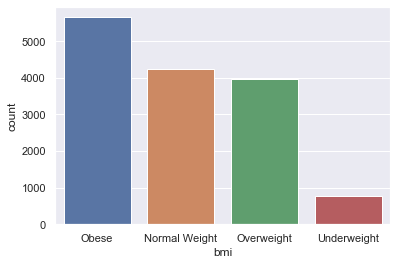

In [15]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [16]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

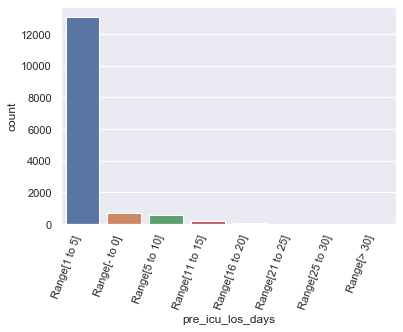

In [17]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['pre_icu_los_days'], order = final_X['pre_icu_los_days'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

### Split categorical and numerical variables

In [18]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Other/Unknown' since the dataframe already has that value.
2. **gender** 
> We observe that there are only 6 missing values. Therefore, we decide to impute values as either 'M' or 'F' based on the percentage of these 2 classes in the column. Following that, we encode the values as follows:

Value | Encoding
--- | ---
'F' | 0
'M' | 1

3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [19]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                               0
elective_surgery                  0
ethnicity                       203
gender                            6
hospital_admit_source          3278
icu_admit_source                 16
icu_stay_type                     0
icu_type                          0
pre_icu_los_days                  0
apache_post_operative             0
arf_apache                       59
gcs_unable_apache                89
intubated_apache                 59
ventilated_apache                59
aids                             59
cirrhosis                        59
diabetes_mellitus                59
hepatic_failure                  59
immunosuppression                59
leukemia                         59
lymphoma                         59
solid_tumor_with_metastasis      59
apache_3j_bodysystem            149
apache_2_bodysystem             149
dtype: int64

In [20]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           11324
African American     1490
Other/Unknown         667
Hispanic              624
Asian                 194
Native American       134
Name: ethnicity, dtype: int64


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


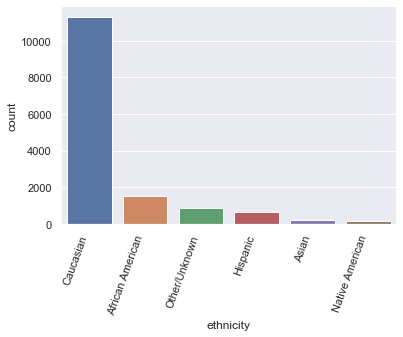

In [21]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [22]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.540602
F    0.459398
Name: gender, dtype: float64

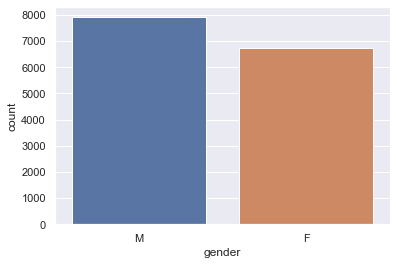

In [23]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

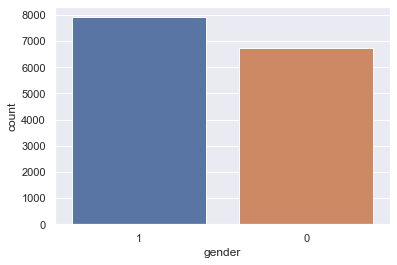

In [24]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [25]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Underweight,1,Caucasian,0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[21 to 25],1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,Obese,0,Other/Unknown,1,NaN,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
2,Obese,0,African American,0,Emergency Department,Accident & Emergency,admit,Cardiac ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,Obese,0,Caucasian,0,Direct Admit,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
4,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,Normal Weight,0,Caucasian,1,NaN,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
6,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Cardiovascular,Cardiovascular
7,Obese,0,Caucasian,1,Direct Admit,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
8,Normal Weight,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
9,Obese,0,Caucasian,0,NaN,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal


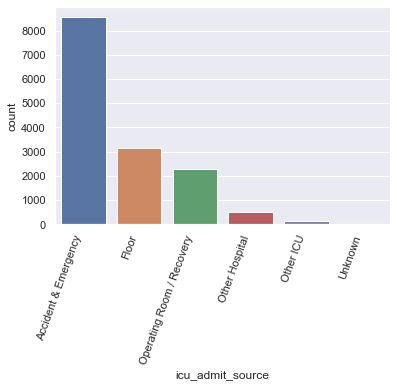

In [26]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [27]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Underweight,1,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[21 to 25],1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Normal Weight,0,Caucasian,1,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
12,Overweight,0,Caucasian,1,Floor,transfer,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,Sepsis,Cardiovascular
15,Normal Weight,0,Caucasian,1,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
16,Normal Weight,0,Caucasian,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
19,Normal Weight,0,Caucasian,1,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
20,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
24,Normal Weight,0,Caucasian,0,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Obese,0,Caucasian,0,Other Hospital,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
27,Underweight,0,Caucasian,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


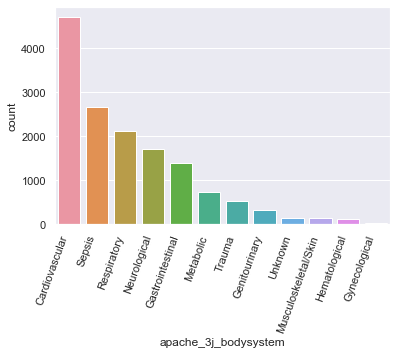

In [28]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [29]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                     59
gcs_unable_apache              89
intubated_apache               59
ventilated_apache              59
aids                           59
cirrhosis                      59
diabetes_mellitus              59
hepatic_failure                59
immunosuppression              59
leukemia                       59
lymphoma                       59
solid_tumor_with_metastasis    59
apache_3j_bodysystem            0
dtype: int64

In [30]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14577, 22)
The shape of X_num after dropping rows is (14577, 118)
The shape of y after dropping rows is (14577,)


In [31]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              30
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [32]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [33]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,45.0,219.0,1504.01,12.0,0.50,4.0,6.0,1.0,197.0,143.0,22.1,47.0,9.0,138.0,35.7,7.61,99.0,41.0,99.0,41.0,143.0,88.0,102.0,47.0,102.0,47.0,23.0,9.0,100.0,94.0,130.0,66.0,130.0,66.0,37.5,35.7,71.0,41.0,71.0,41.0,143.0,106.0,77.0,47.0,77.0,47.0,23.0,9.0,100.0,99.0,99.0,66.0,99.0,66.0,36.4,35.7,12.0,12.0,8.7,7.6,0.60,0.50,197.0,173.0,24.0,18.0,10.8,7.8,30.0,22.1,290.0,250.0,4.3,3.9,140.0,138.0,13.93,7.61,0.19,0.05,1,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,29.0,307.0,704.01,19.0,1.68,4.0,6.0,5.0,463.0,126.0,35.3,44.0,9.0,135.0,36.1,10.60,101.0,34.0,101.0,34.0,118.0,88.0,107.0,44.0,107.0,44.0,28.0,13.0,100.0,90.0,122.0,82.0,122.0,82.0,37.0,36.1,47.0,41.0,47.0,41.0,112.0,108.0,61.0,53.0,61.0,53.0,23.0,21.0,100.0,100.0,109.0,105.0,109.0,105.0,37.0,37.0,19.0,13.0,8.6,8.0,1.68,1.44,463.0,193.0,20.0,12.0,12.0,12.0,36.1,35.3,322.0,308.0,5.0,4.0,137.0,135.0,11.00,10.60,0.02,0.01,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,33.0,122.0,703.03,6.0,0.77,4.0,6.0,5.0,97.0,108.0,21.4,66.0,29.0,137.0,36.9,6.10,88.0,64.0,88.0,64.0,119.0,90.0,97.0,77.0,

In [34]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)

In [35]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(11661, 141)
(11661,)
(2916, 141)
(2916,)


In [36]:
# Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean")

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
AUC Train:  0.8900347850459602
AUC Validation:  0.7057709994049062
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 depth
AUC Train:  0.8863176495277774
AUC Validation:  0.6898081351451159
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 depth
AUC Train:  0.9491417405901843
AUC Validation:  0.7318511653725923
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 depth
AUC Train:  0.9493161247256053
AUC Validation:  0.735377273058712
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
AUC Train:  0.9725264236973215
AUC Validation:  0.7547707477248832
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 depth
AUC Train:  0.9755386095830435
AUC Validation:  0.7393312367838585
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 depth
AUC Train:  0.9829186503303327
AUC Validation:  0.7540914468778741
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 depth
AUC Train:  0.9849451598959555
AUC Validation:  0.7526088868921751
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 depth
AUC Train:  0.9885845462120606
AUC Validation:  0.7619412762294099
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
AUC Train:  0.9893066606797134
AUC Validation:  0.763208849728209
 
20 depth
AUC Train:  0.9979451618374793
AUC Validation:  0.7757676828737624
 
50 depth
AUC Train:  0.9998293224099676
AUC Validation:  0.7849398908132088
 
75 depth
AUC Train:  1.0
AUC Validation:  0.7893536998139449
 


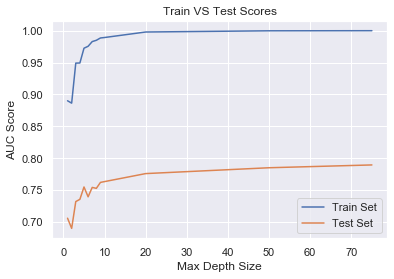

In [37]:
# Broad search
# Testing various max_depth_size levels for Random Forest and assessing with AUC
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,6,7,8,9,10,20,50,75]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(X_train_imp, y_train)
    print(depth, 'depth')
    # Predicting on training and testing sets
    pred = model.predict(X_train_imp)
    pred2 = model.predict(X_test_imp)
    # Generating the ROC score
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Validation: ', roc2)
    # Appending results to the proper lists
    results.append(roc1)
    results2.append(roc2)
    print (" ")

# Plotting the results AUC score against the max_depth_size
plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

auto max_features
AUC:  0.7984735442929423
 
log2 max_features
AUC:  0.7963296458279736
 
0.3 max_features
AUC:  0.797873252722751
 
0.5 max_features
AUC:  0.7980447645999486
 
0.7 max_features
AUC:  0.7947860389331961
 


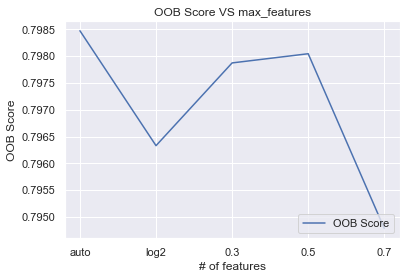

In [38]:
# Broad search
# Testing various max_features_options for Random Forest and assessing with AUC
results = []
max_features_options = ["auto", "log2", 0.3, 0.5, 0.7]

for features in max_features_options:
    model = RandomForestClassifier(max_features=features, oob_score=True, random_state=42, max_depth=150, n_estimators=500)
    #model.fit(X, y)
    model.fit(X_train_imp, y_train)
    print(features, 'max_features')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(max_features_options, results, label='OOB Score')
plt.xlabel('# of features')
plt.ylabel('OOB Score')
plt.title('OOB Score VS max_features')
plt.legend(loc="lower right")
plt.show()


1 min samples
AUC:  0.7929851642226224
 
2 min samples
AUC:  0.7936712117314124
 
4 min samples
AUC:  0.7940142354858074
 
5 min samples
AUC:  0.7938427236086099
 
10 min samples
AUC:  0.7928136523454249
 
15 min samples
AUC:  0.7932424320384187
 
20 min samples
AUC:  0.7912700454506475
 


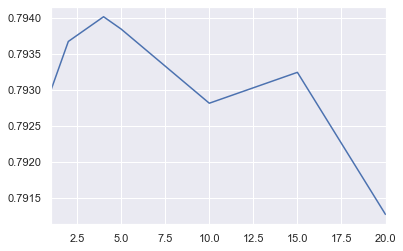

In [39]:
# Broad search
# Testing various min_samples_leaf_options for Random Forest and assessing with AUC
results = []
min_samples_leaf_options = [1, 2, 4, 5, 10, 15, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=500, max_depth=9, max_features=0.3, oob_score=True, random_state=42, min_samples_leaf=min_samples)
    model.fit(X_train_imp, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

In [40]:
# From hyper-parameters previously identified, 
# we will perform gridsearch with a finer range to find the optimal values  

parameters = {"max_depth": [90, 100, 110, 120], 
            "max_features": [0.3], 
            "min_samples_leaf": [8,9,10,11,12]}

model_rf = RandomForestClassifier(random_state=42, n_estimators=500)


# fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)


# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model_rf, param_grid=parameters, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_imp, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test_imp)


# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the validation data: {:.4f}".format(f1_score(y_test, best_predictions)))
print(best_clf)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



Optimized Model
------
Final accuracy score on the validation data: 0.7898
Final F-score on the validation data: 0.7919
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features=0.3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [41]:
# Re-creation of the optimal model
model_rf = RandomForestClassifier(random_state=42, 
                                  n_estimators=500, 
                                  max_depth=90, 
                                  max_features=0.3,
                                  min_samples_leaf=8,
                                  min_samples_split=2)

# Prediction on the testing dataset
rf_model = model_rf.fit(X_train_imp, y_train)
y_pred = rf_model.predict(X_test_imp)

# Printing the confusion matrix
print(confusion_matrix(y_test, y_pred))
print('Accuracy score: {0:.2f}'.format(accuracy_score(y_test, y_pred)))

[[1137  314]
 [ 299 1166]]
Accuracy score: 0.79


For the Random Forest model with a down-sampled dataset, the accuracy is fairly low.
However, the distribution in the confusion matrix is well balanced showing that our model
is not inclined to choose the majority class (which of course was taken care of via the SMOTE
approach.

In [42]:
# Let's try to build a logistic regression model

# Standardization of training and test sets
scaler = StandardScaler()

# Fitting and transforming the training set for standardization
X_train_imp_sc = scaler.fit_transform(X_train_imp)

# Transforming the testing set with the standardization object
X_test_imp_sc = scaler.transform(X_test_imp)


In [43]:
# Function to create, train, and assess a model
def model_building(dict_params, model_obj, X_data, y_data, X_toPredict, y_toPredict):

    parameters = dict_params

    # model as an object
    model = model_obj

    # fbeta_score scoring object using make_scorer()
    scorer = make_scorer(f1_score)

    # Grid Search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(model, param_grid=dict_params, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_data, y_data)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the model
    best_predictions = best_clf.predict(X_toPredict)
    
    # Give the probability from the predictions
    best_predictions_prob = best_clf.predict_proba(X_toPredict)[:,1]
    
    # Report the scores
    print("\nOptimized Model\n------")
    print("Final accuracy score on the data: {:.4f}".format(accuracy_score(y_toPredict, best_predictions)))
    print("Final F1-score on the data: {:.4f}".format(f1_score(y_toPredict, best_predictions)))
    print(best_clf)
    
    return(best_clf, best_predictions, best_predictions_prob)


In [44]:
# Aplying the previous function with the Logistic Regression model
dict_params = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_training, train_predictions, train_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_train_imp_sc,
               y_toPredict=y_train)

lr_model_validation, test_predictions, test_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_test_imp_sc,
               y_toPredict=y_test)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Def


Optimized Model
------
Final accuracy score on the data: 0.7956
Final F1-score on the data: 0.7942
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Def


Optimized Model
------
Final accuracy score on the data: 0.7846
Final F1-score on the data: 0.7821
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [45]:
# Aplying the previous function with the Logistic Regression model with a fine-tuned parameters
parameters = {"C": [0.1, 0.4, 0.7, 1, 1.3, 1.7, 2]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_validation_finetuned, best_test_predictions, best_test_predictions_prob = model_building(dict_params=parameters, 
               model_obj=lr_model,
               X_data=X_train_imp_sc, 
               y_data=y_train,
               X_toPredict=X_test_imp_sc,
               y_toPredict=y_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Def


Optimized Model
------
Final accuracy score on the data: 0.7840
Final F1-score on the data: 0.7816
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [46]:
# Function to generate the confusion matrix and
# extract precision and recall from model
def conf_matrix_with_metrics(true_predictions, predictions):
    confmat = confusion_matrix(true_predictions, predictions)
    print("The Confusion Matrix:\n", confmat)
    print("Accuracy Score:", round(accuracy_score(true_predictions, predictions), 2))
    print("Precision Score:", round(precision_score(true_predictions, predictions), 2))
    print("Recall Score:", round(recall_score(true_predictions, predictions), 2))
    
conf_matrix_with_metrics(y_train, train_predictions)

The Confusion Matrix:
 [[4678 1124]
 [1260 4599]]
Accuracy Score: 0.8
Precision Score: 0.8
Recall Score: 0.78


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


age                              0.013425
apache_2_diagnosis               0.006379
apache_3j_diagnosis              0.013042
bun_apache                       0.006895
creatinine_apache                0.012208
gcs_eyes_apache                  0.013649
gcs_motor_apache                 0.017607
gcs_verbal_apache                0.042124
glucose_apache                   0.008055
heart_rate_apache                0.010857
hematocrit_apache                0.008168
map_apache                       0.008459
resprate_apache                  0.008410
sodium_apache                    0.006687
temp_apache                      0.008252
wbc_apache                       0.009704
d1_diasbp_max                    0.007521
d1_diasbp_min                    0.006913
d1_diasbp_noninvasive_max        0.007258
d1_diasbp_noninvasive_min        0.008561
d1_heartrate_max                 0.017231
d1_heartrate_min                 0.009813
d1_mbp_max                       0.007844
d1_mbp_min                       0

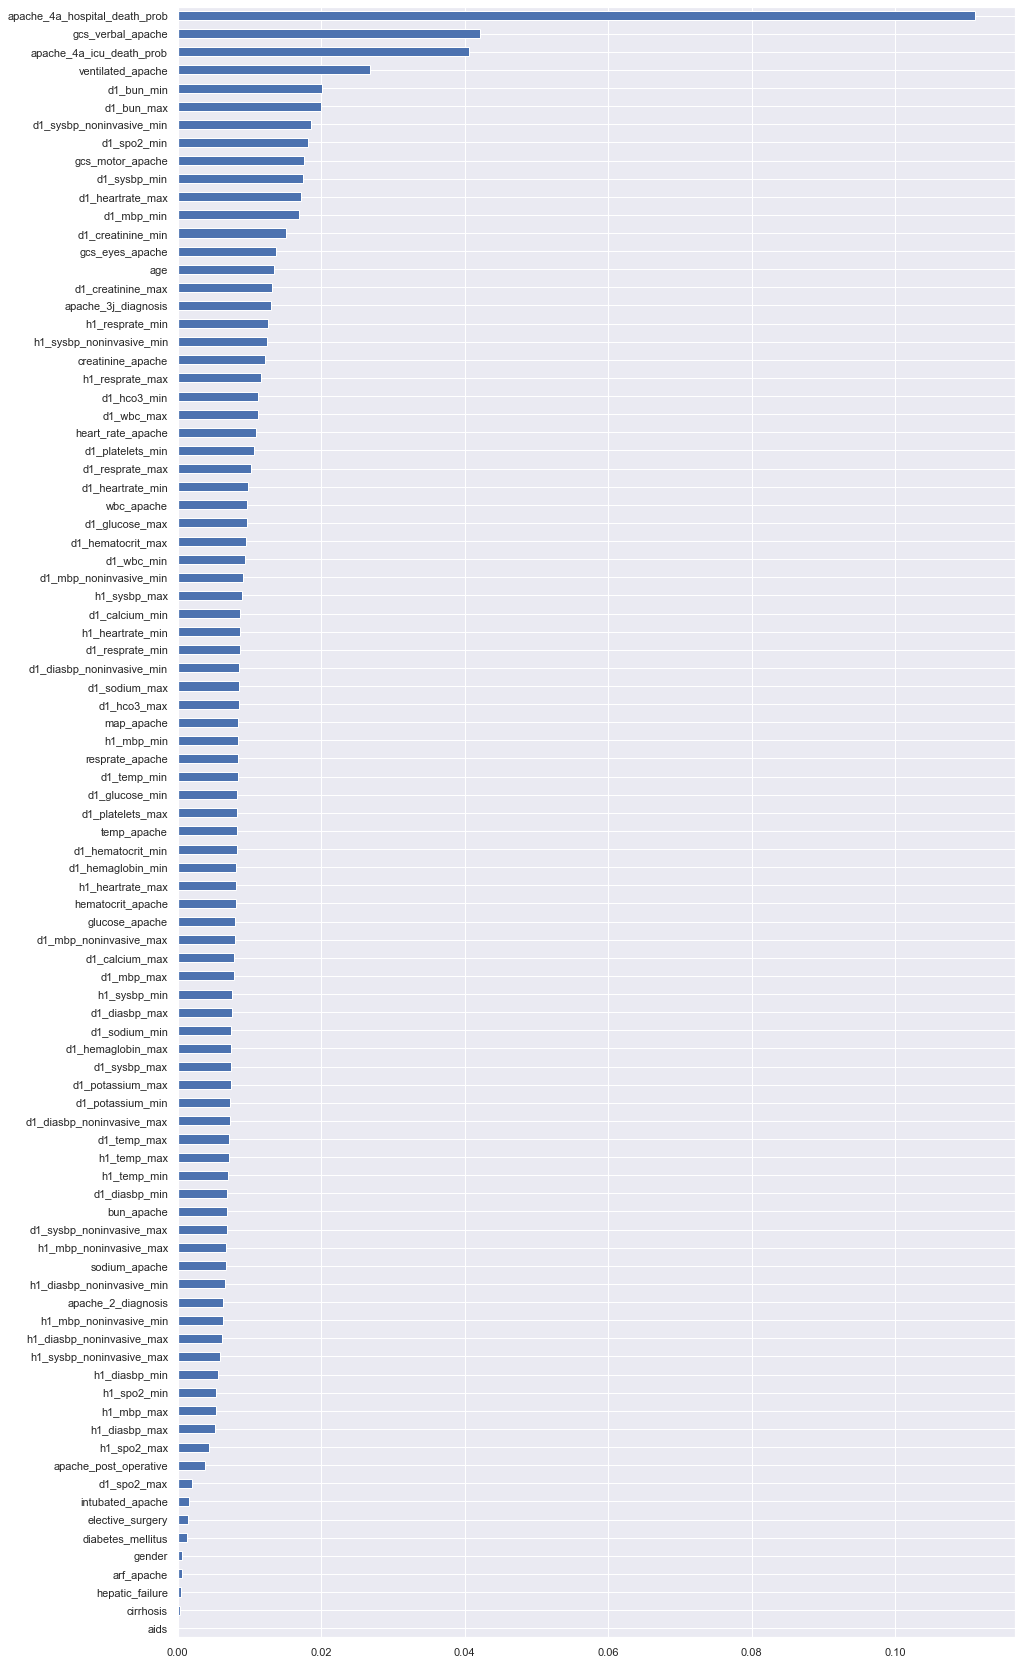

In [47]:
#Generating the random forest feature importances
from sklearn.ensemble import RandomForestClassifier

# Fitting the random forest classifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_imp_sc, y_train)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, index=new_dataset.columns)

# Extracting the most important first 90 features
sub_feature_importances = feature_importances[:90]
print(sub_feature_importances)


sub_feature_importances.sort_values(inplace=True)
sub_feature_importances.plot(kind='barh', figsize=(15,30))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


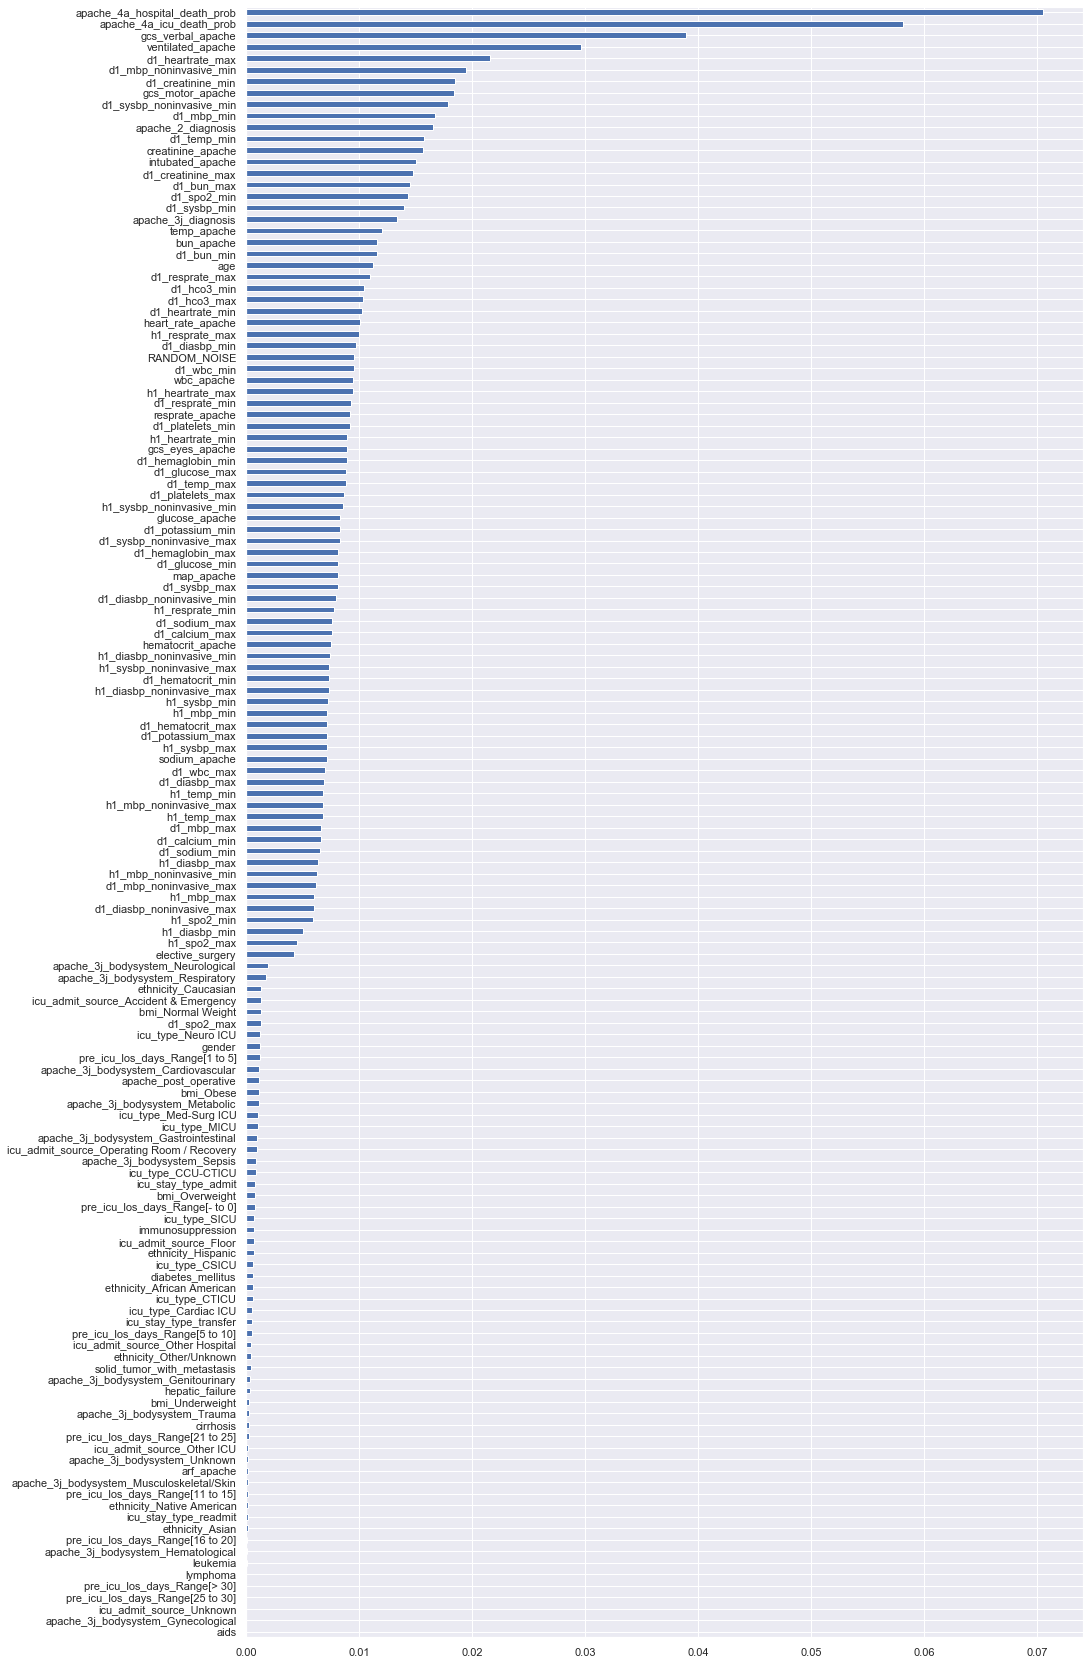

In [49]:
# Apply Random Noise to data set
X_train_rnoise = pd.DataFrame(X_train_imp_sc)
X_train_rnoise[X_train_rnoise.shape[1]] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet

model_rf2 = RandomForestClassifier(random_state=42)
model_rf2.fit(X_train_rnoise, y_train)

# Generate indices for plot
indices = new_dataset.columns
indices = indices.append(pd.Index(["RANDOM_NOISE"]))

# Get Feature Importances
feature_importances_random = pd.Series(model_rf2.feature_importances_, index = indices)
sub_feature_importances_random = feature_importances_random[:]

sub_feature_importances_random.sort_values(inplace=True)
sub_feature_importances_random.plot(kind='barh', figsize=(15,30))
#feature_importances_random.sort_values(inplace=True)


In [50]:
# Now we are going to try Gradient Boosting
# Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42, n_estimators=500, max_features='auto')
    
#model.fit(X, y)
model.fit(X_train_imp_sc, y_train)
y_pred = model.predict(X_train_imp_sc)
print('accuracy score: ', round(accuracy_score(y_train, y_pred),2 ))
print('confusion matrix: ', confusion_matrix(y_train, y_pred))


accuracy score:  0.9
confusion matrix:  [[5216  586]
 [ 609 5250]]


In [51]:
#model.fit(X, y)
y_pred = model.predict(X_test_imp_sc)
print('accuracy score: ',round(accuracy_score(y_test, y_pred), 2))
print('confusion matrix: ', confusion_matrix(y_test, y_pred))


accuracy score:  0.79
confusion matrix:  [[1141  310]
 [ 295 1170]]


In [52]:
#########################################
## Now we will replicate the same approaches but with an upsampled dataset
#########################################

In [53]:
X = data.drop('hospital_death', axis = 1)
y = data['hospital_death']
X.info()

# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

row_majority_X.isnull().mean()

# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 129.4+ MB
The shape of X after dropping rows is (84284, 185)
The shape of y after dropping rows is (84284,)
The shape of X after dropping columns is (84284, 133)


In [54]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

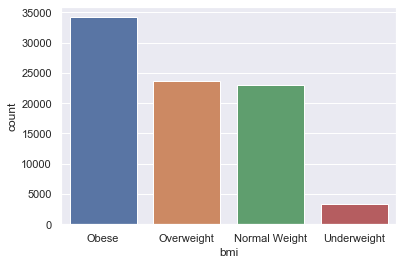

In [55]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [56]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

In [57]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

In [58]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                                0
elective_surgery                   0
ethnicity                       1182
gender                            14
hospital_admit_source          19824
icu_admit_source                  85
icu_stay_type                      0
icu_type                           0
pre_icu_los_days                   0
apache_post_operative              0
arf_apache                       218
gcs_unable_apache                390
intubated_apache                 218
ventilated_apache                218
aids                             218
cirrhosis                        218
diabetes_mellitus                218
hepatic_failure                  218
immunosuppression                218
leukemia                         218
lymphoma                         218
solid_tumor_with_metastasis      218
apache_3j_bodysystem             935
apache_2_bodysystem              935
dtype: int64

In [59]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           64997
African American     8730
Other/Unknown        4052
Hispanic             3518
Asian                1057
Native American       748
Name: ethnicity, dtype: int64


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


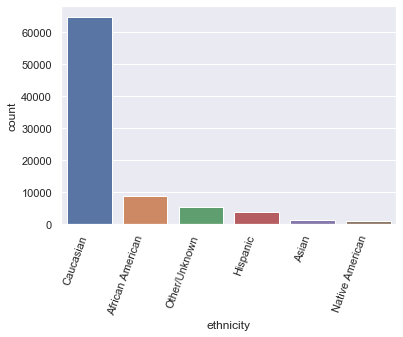

In [60]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [61]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.542613
F    0.457387
Name: gender, dtype: float64

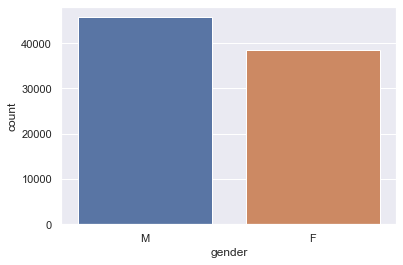

In [62]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

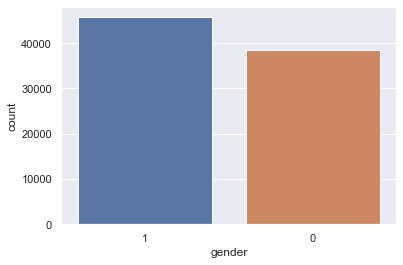

In [63]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [64]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
2,Normal Weight,1,Caucasian,0,Operating Room,Operating Room / Recovery,admit,CTICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,Overweight,0,Caucasian,1,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
4,Obese,0,Caucasian,0,Operating Room,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
5,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
7,Overweight,0,Other/Unknown,1,Direct Admit,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,Overweight,1,Hispanic,0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
9,Overweight,1,Caucasian,0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Neurological,Neurologic
10,Obese,1,Caucasian,1,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
11,Obese,1,Caucasian,1,Operating Room,Operating Room / Recovery,admit,MICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
12,Obese,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


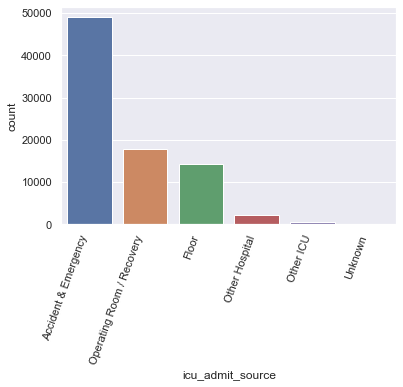

In [65]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [66]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Normal Weight,0,Caucasian,1,Floor,admit,CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
3,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Obese,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
9,Overweight,1,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Neurological,Neurologic
12,Obese,0,Caucasian,0,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
15,Overweight,0,Hispanic,1,Accident & Emergency,admit,Neuro ICU,Range[- to 0],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
17,Obese,0,Caucasian,1,Floor,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
18,Obese,1,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Genitourinary,Renal/Genitourinary
19,Normal Weight,0,Caucasian,1,Floor,admit,MICU,Range[5 to 10],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
21,Overweight,0,Caucasian,0,Floor,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


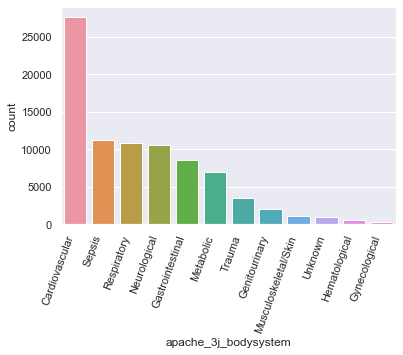

In [67]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [68]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (84066, 22)
The shape of X_num after dropping rows is (84066, 109)
The shape of y after dropping rows is (84066,)


In [69]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

In [70]:
# Removing columns with more than len(X_num)-5000.
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)

# Concatenating the numerical and categorical features 
tmp = pd.concat([X_num_nonan, X_cat], axis=1)

# One-hot encoding the dataset
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,heart_rate_apache,map_apache,resprate_apache,temp_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,68.0,113.0,502.01,3.0,6.0,4.0,118.0,40.0,36.0,39.3,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,68.0,63.0,119.0,108.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,31.0,30.0,2.51,2.23,168.0,109.0,4.0,3.4,136.0,134.0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,77.0,108.0,203.01,1.0,3.0,1.0,120.0,46.0,33.0,35.1,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,35.1,61.0,48.0,114.0,100.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,11.0,9.0,0.71,0.56,145.0,128.0,4.2,3.8,145.0,145.0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,81.0,203.0,1206.03,4.0,6.0,5.0,114.0,60.0,4.0,34.8,48.0,42.0,48.0,42.0,116.0,92.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,158.0,84.0,158.0,84.0,38.0,34.8,62.0,44.0,100.0,96.0,92.0,71.0,12.0,11.0,100.0,99.0,136.0,106.0,NaN,NaN,NaN,NaN,185.0,88.0,5.0,3.5,NaN,NaN,1,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,67.0,301.0,403.01,4.0,6.0,5.0,113.0,130.0,35.0,36.6,100.0,61.0,100.0,61.0,113.0,83.0,127.0,80.0,127.0,80.0,32.0,10.0,97.0,91.0,173.0,107.0,173.0,107.0,36.8,36.6,89.0,89.0,83.0,83.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,13.0,13.0,0.71,0.71,156.0,125.0,3.9,3.7,137.0,137.0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,59.0,108.0,203.01,4.0,6.0,5.0,133.0,138.0,53.0,35.0,76.0,68.0,76.0,68.0,112.0,70.

In [71]:
# Creating the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)


In [72]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(67252, 113)
(67252,)
(16814, 113)
(16814,)


In [73]:
# Creating an imputer object with the strategy of using the mean
imp = Imputer(strategy="mean")

# Fitting and transforming the training set
X_train_imp = imp.fit_transform(X_train)

# Transforming the testing set with the imputing object created based on the training set
X_test_imp = imp.transform(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [74]:
# Upsampling training set
# Upsample using SMOTE
sm = SMOTE(random_state=42, ratio=1.0)
X_train_imp_sm, y_train_sm = sm.fit_sample(X_train_imp, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
AUC Train:  0.9590751388594791
AUC Validation:  0.6153249858747232
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 depth
AUC Train:  0.9623654162526674
AUC Validation:  0.5613821491633678
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 depth
AUC Train:  0.9878080562930627
AUC Validation:  0.6248386961207687
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 depth
AUC Train:  0.9877836235401429
AUC Validation:  0.5857815775260342
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
AUC Train:  0.9942664473148403
AUC Validation:  0.6292482951274522
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 depth
AUC Train:  0.9935986187350351
AUC Validation:  0.5962174276453402
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 depth
AUC Train:  0.9967097226068118
AUC Validation:  0.627877993185624
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 depth
AUC Train:  0.9962210675484178
AUC Validation:  0.5986731467647946
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 depth
AUC Train:  0.9980046585115567
AUC Validation:  0.630645413415333
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
AUC Train:  0.9976870327236005
AUC Validation:  0.6112359822887595
 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


20 depth
AUC Train:  0.9995276334435522
AUC Validation:  0.6203251670962989
 
50 depth
AUC Train:  0.9999755672470803
AUC Validation:  0.6258199831586231
 
75 depth
AUC Train:  1.0
AUC Validation:  0.6338156569660128
 


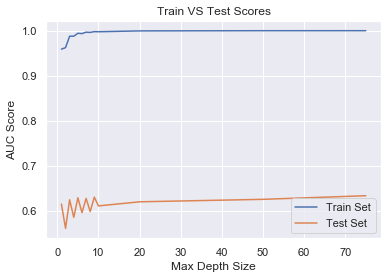

In [75]:
# Broad search
# Testing various max_depth_size levels for Random Forest and assessing with AUC
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,6,7,8,9,10,20,50,75]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(X_train_imp_sm, y_train_sm)
    print(depth, 'depth')
    # Predicting on training and testing sets
    pred = model.predict(X_train_imp_sm)
    pred2 = model.predict(X_test_imp)
    # Generating the ROC score
    roc1 = roc_auc_score(y_train_sm, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Validation: ', roc2)
    # Appending results to the proper lists
    results.append(roc1)
    results2.append(roc2)
    print (" ")

# Plotting the results AUC score against the max_depth_size
plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

In [76]:
# Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42, n_estimators=500, max_features='auto')
    
#model.fit(X, y)
model.fit(X_train_imp_sm, y_train_sm)
y_pred = model.predict(X_train_imp_sm)
print('accuracy score: ', round(accuracy_score(y_train_sm, y_pred),2 ))
print('confusion matrix: ', confusion_matrix(y_train_sm, y_pred))


accuracy score:  0.96
confusion matrix:  [[60798   595]
 [ 3716 57677]]


In [77]:
# Prediction on the test set
y_pred = model.predict(X_test_imp)
print(confusion_matrix(y_test, y_pred))
print('accuracy score: ',round(accuracy_score(y_test, y_pred), 2))

[[15115   234]
 [ 1001   464]]
accuracy score:  0.93


In [78]:
y_test.value_counts()

0    15349
1     1465
Name: hospital_death, dtype: int64